# 2021-11-08 Galerkin properties

## Last time

* Variational forms
* Finite element definition
* From prime to nodal bases
* Galerkin method

## Today

* Stable numerics
* Galerkin optimality
* Boundary conditions
* Properties of Galerkin methods

In [52]:
using Plots
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature

default(linewidth=4)

# Finite elements

## Problem statement

Find $u \in \mathcal V$ such that
\begin{align} \int_\Omega \nabla v \cdot \kappa \nabla u - \int_{\partial\Omega} v \underbrace{\kappa \nabla u \cdot \mathbf n}_{\text{boundary condition}} = 0, \forall v \in \mathcal V
\end{align}

### What do we need?
* A way to integrate
* A space $\mathcal V$
* Boundary conditions

## Ciarlet (1978) definition

A **finite element** is a triple $(K, P, N)$ where
* $K$ is a bounded domain with piecewise smooth boundary
* $P = \{p_j\}_1^k$ is a finite-dimensional function space over $K$ ("prime basis")
* $N = \{n_i\}_1^k$ is a basis for the dual space ("nodes")

It is common for nodes to be pointwise evaluation
$$ \langle n_i, p_j \rangle = p_j(x_i) $$

### First: choose a single element $K = \Omega$

# Legendre polynomials

In [5]:
function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

vander_legendre_deriv (generic function with 2 methods)

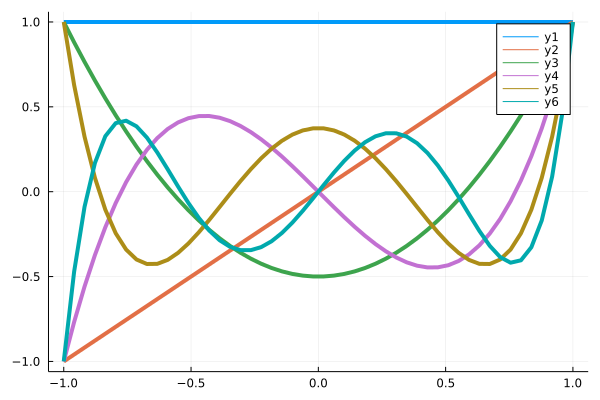

In [74]:
x = LinRange(-1, 1, 50)
P, dP = vander_legendre_deriv(x, 6)
plot(x, P)

# Prime to nodal basis

A **nodal basis** $\{ \phi_j(x) \}$ is one that satisfies
$ n_i(\phi_j) = \delta_{ij} . $

We write $\phi_j$ in the prime basis by solving with the generalized Vandermonde matrix $V_{ij} = \langle n_i, p_j \rangle$,
$$ \phi_j(x) = \sum_k p_k(x) (V^{-1})_{k,j} . $$

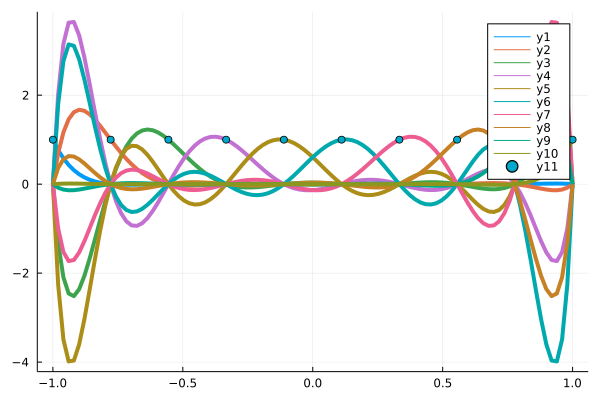

In [124]:
k = 10
xn = LinRange(-1, 1, k)
V, _ = vander_legendre_deriv(xn)
xx = LinRange(-1, 1, 100)
Pxx, dPxx = vander_legendre_deriv(xx, k)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

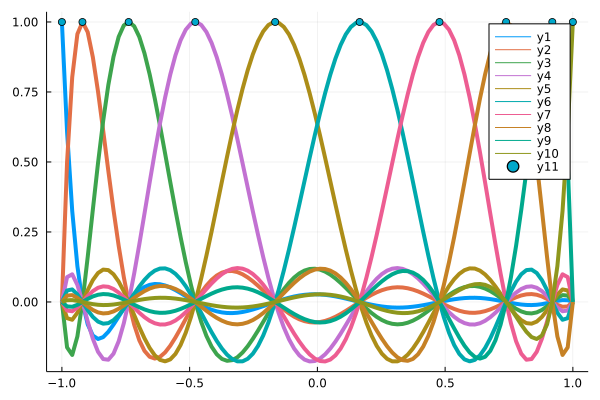

In [125]:
using FastGaussQuadrature
xn, _ = gausslobatto(k)
V, _ = vander_legendre_deriv(xn)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

# Galerkin method: $L^2$ projection

A nice test problem that doesn't require derivatives or boundary conditions:
Find $u \in \mathcal V_h$ such that
$$ \int_{-1}^1 v(x) \big[ u(x) - f(x) \big] = 0, \quad \forall v \in \mathcal V_h$$

In [127]:
function febasis(P, Q)
    x, _ = gausslobatto(P)
    q, w = gausslegendre(Q)
    Pk, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / Pk
    D = Dp / Pk
    x, q, w, B, D
end

function L2_galerkin(P, Q, f)
    x, q, w, B, _ = febasis(P, Q)
    A = B' * diagm(w) * B
    rhs = B' * diagm(w) * f.(q)
    # Jacobi-preconditioned mass matrix
    @show cond(diagm(1 ./diag(A))*A)
    u = A \ rhs
    x, u
end

L2_galerkin (generic function with 1 method)

cond(diagm(1 ./ diag(A)) * A) = 3.3017338015935196


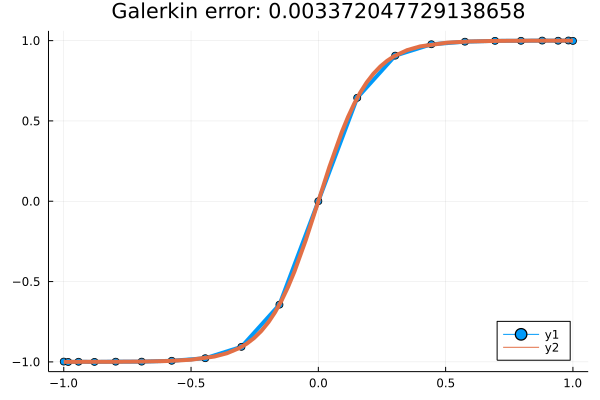

In [128]:
f(x) = tanh(5*x)
x, u = L2_galerkin(21, 21, f)
error = u - f.(x)
plot(x, u, marker=:auto, legend=:bottomright)
plot!(f, title="Galerkin error: $(norm(error))")

# Convergence of the Galerkin method

cond(diagm(1 ./ diag(A)) * A) = 3.0427819528043325
cond(diagm(1 ./ diag(A)) * A) = 3.1322436723153646
cond(diagm(1 ./ diag(A)) * A) = 3.2505611535481065
cond(diagm(1 ./ diag(A)) * A) = 3.38441899614129
cond(diagm(1 ./ diag(A)) * A) = 3.5263870880278505
cond(diagm(1 ./ diag(A)) * A) = 3.67240818371252
cond(diagm(1 ./ diag(A)) * A) = 3.8202852157623814


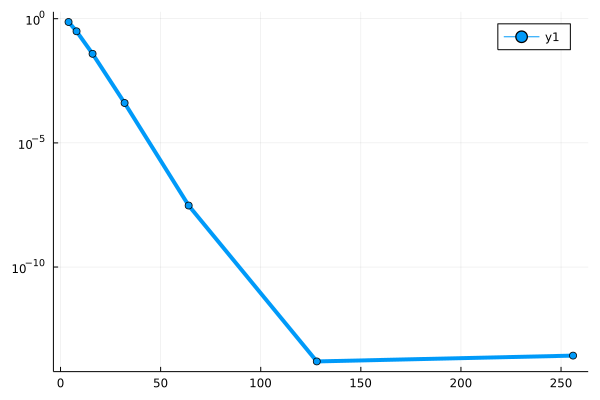

In [101]:
ns = 2 .^ (2:8)
function L2_error(n)
    x, u = L2_galerkin(n, n, f)
    norm(u - f.(x))
end
plot(ns, L2_error.(ns), marker=:auto, yscale=:log10)

# Galerkin error estimates

We introduce the notation
$$ a(v, u) = \int_\Omega \nabla v(x) \cdot \nabla u(x) $$
and note that $a$ is
* bilinear (linear in each of its arguments)
* symmetric: $a(u, v) = a(v,u)$
* positive definite: $a(u, u) > 0$ when $u \ne 0$
thus defines an inner product on the function space $V$.

We also introduce the $L^2$ inner product
$$ \langle u, v \rangle = \int_\Omega u(x) v(x) $$
so that our continuous weak form is to find $u \in V$ such that
$$ a(v, u) = \langle v, f \rangle, \quad \forall v\in V. $$
Our Galerkin discretization is to find $u_h \in V_h \subset V$ such that
$$ a(v_h, u_h) = \langle v_h, f \rangle, \quad \forall v_h \in V_h . $$
Since $V_h \subset V$, we can subtract these two, yielding
$$ a(v_h, u_h - u) = 0, \quad \forall v_h \in V_h .$$
This says that the error in the discrete solution $u_h - u$ is $a$-orthogonal to all test functions $v_h$.

# Galerkin optimality via energy norms

We can also define the "energy norm" or $a$-norm,
$$ \lVert u \rVert_a = \sqrt{a(u,u)} . $$
This norm satisfies the Cauchy-Schwarz inequality,
$$ \lvert a(u,v) \rvert \le \lVert u \rVert_a \lVert v \rVert_a . $$
Now,
\begin{align}
\lVert u_h - u \rVert_a^2 &= a(u_h - u, u_h - u) \\
&= a(u_h - v_h, u_h - u) + a(v_h - u, u_h - u) \\
&= a(v_h - u, u_h - u) \\
&\le \lVert v_h - u \rVert_a \lVert u_h - u \rVert_a .
\end{align}
In other words,
$$\lVert u_h - u \rVert_a \le \lVert v_h - u \rVert_a, \quad \forall v_h \in V_h .$$
So the solution $u_h$ computed by the Galerkin discretization is optimal over the subspace $V_h$ as measured in the $a$-norm.

## Observations
* The Galerkin method computes the exact solution any time it resides in the subspace $V_h$.
* The Galerkin method is automatically symmetric any time the weak form is symmetric.
* The Galerkin method can be spectrally accurate, similar to the Chebyshev finite difference methods.
* For a nonlinear problem, discretization and differentiation will commute.

# Galerkin method for Poisson

$$ \int_{\Omega} \nabla v \cdot \kappa \cdot \nabla u = \int_{\Omega} v f, \forall v$$

In [109]:
function poisson_galerkin(P, Q, kappa, f)
    x, q, w, B, D = febasis(P, Q)
    A = D' * diagm(w .* kappa.(q)) * D
    rhs = B' * diagm(w) * f.(q)
    # Boundary conditions
    rhs[[1]] .= 0
    A[1, :] .= 0
    A[1, 1] = 1
    #A[end, :] .= 0
    #A[end, end] = 1
    u = A \ rhs
    x, u
end

poisson_galerkin (generic function with 1 method)

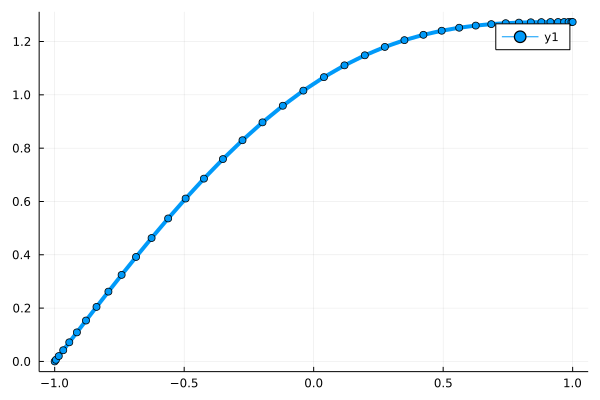

In [111]:
kappa(x) = 0.6 .+ 0.4 * sin.(pi*x)
x, u = poisson_galerkin(40, 40, one, x -> cos(x*pi/2))
plot(x, u, marker=:auto)
#uexact(x) = cos(x*pi/2) * (2/pi)^2
#plot!(uexact, title="Error: $(norm(u - uexact.(x)))")

## What if we only impose the boundary condition on one side?

# Galerkin preserves symmetry

The bilinear operator is symmetric if $a(v,u) = a(u,v)$,

$$ a(v,u) = \int_{\Omega} \nabla v \cdot \kappa \cdot \nabla u $$

This is symmetric even for
* variable coefficients
* any Neumann-type boundary conditions
* Dirichlet if eliminated or lifted symmetrically
* arbitrary grid spacing (and mesh topology in multiple dimensions)

In [123]:
x, q, w, B, D = febasis(7, 10)
A = D' * diagm(w .* kappa.(q)) * D
@show norm(A - A')
eigvals(A)

norm(A - A') = 7.765675694969792e-16


7-element Vector{Float64}:
  1.1350210845831068e-15
  0.21130426481190864
  1.3866142540744655
  3.2701200000673087
  6.853818219483833
 10.692355373099744
 14.545787888462765

## What if we use too few quadrature points?

![](../img/libCEED-2-trim.svg)

# General form
$$ \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
we discretize as
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

## Isoparametric mapping

Given the reference coordinates $X \in \hat K \subset R^n$ and physical coordinates $x(X)$, an integral on the physical element can be written
$$ \int_{K = x(\hat K)} f(x) dx = \int_K \underbrace{\left\lvert \frac{\partial x}{\partial X} \right\rvert}_{\text{determinant}} f(x(X)) dX .$$

| Notation | Meaning |
|---------|:-------------|
| $x$ | physical coordinates |
| $X$ | reference coordinates |
| $\mathcal E_e$ | restriction from global vector to element $e$ |
| $B$ | values of nodal basis functions at quadrature ponits on reference element |
| $D$ | gradients of nodal basis functions at quadrature points on reference element|
| $W$ | diagonal matrix of quadrature weights on reference element |
| $\frac{\partial x}{\partial X} = D \mathcal E_e x $ | gradient of physical coordinates with respect to reference coordinates |
| $\left\lvert \frac{\partial x}{\partial X}\right\rvert$ | determinant of coordinate transformation at each quadrature point |
| $\frac{\partial X}{\partial x} = \left(\frac{\partial x}{\partial X}\right)^{-1}$ | derivative of reference coordinates with respect to physical coordinates |

# Finite element mesh and restriction

In [64]:
function fe1_mesh(P, nelem)
    x = LinRange(-1, 1, nelem+1)
    rows = Int[]
    cols = Int[]
    for i in 1:nelem
        append!(rows, (i-1)*P+1:i*P)
        append!(cols, (i-1)*(P-1)+1:i*(P-1)+1)
    end
    x, sparse(rows, cols, ones(nelem*P))
end
P, nelem = 4, 3
x, E = fe1_mesh(P, nelem)

(range(-1.0, stop=1.0, length=4), 
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0)

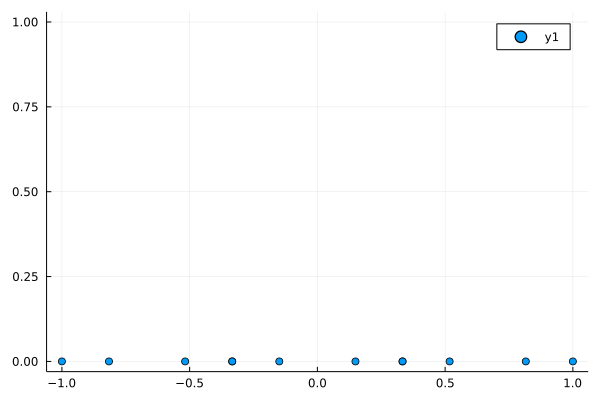

In [72]:
function xnodal(x, P)
    xn = Float64[]
    xref, _ = gausslobatto(P)
    for i in 1:nelem
        xL, xR = x[i:i+1]
        append!(xn, (xL+xR)/2 .+ (xR-xL)/2 * xref)
    end
    xn
end
xn = xnodal(x, 4)
scatter(xn, zero, marker=:auto)

# Finite element assembly

In [ ]:
function fe_assemble(P, Q, nelem)
    x, E = fe1_mesh(P, nelem)
    